# Initializing and training GPT-2 model

In [1]:
from tqdm.notebook import tqdm
from datasets import load_dataset, DatasetDict, load_from_disk
from transformers import BertTokenizer, BertForMaskedLM, GPT2Tokenizer, GPT2Config, GPT2Model, GPT2LMHeadModel, GPT2LMHeadModel
from transformers import DataCollatorForLanguageModeling, DataCollatorWithPadding
from transformers import Trainer, TrainingArguments
import random

## Loading in the data

In [2]:
def load_data_in_splits(data_dir, train=0.8, val=0.1, test=0.1):
    data = load_dataset(data_dir)
    train_valtest = data['train'].train_test_split(test_size = 1 - train)
    test_valid = train_valtest['test'].train_test_split(test_size = test / (val + test))
    out = DatasetDict({
            'train': train_valtest['train'],
            'val': test_valid['train'],
            'test': test_valid['test']
        })
    return out

coca_dir = "../data/coca_spoken/text_cleaned/"

coca_dsdict = load_data_in_splits(coca_dir, .8, .1, .1)
coca_dsdict

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 4802969
    })
    val: Dataset({
        features: ['text'],
        num_rows: 600371
    })
    test: Dataset({
        features: ['text'],
        num_rows: 600372
    })
})

In [3]:
for split in ['train', 'val', 'test']:
    print(split, random.choice(coca_dsdict[split]))

train {'text': 'I am Ira Flatow .'}
val {'text': 'OK. '}
test {'text': 'But first , the ownership society .'}


### Text data stats

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [30]:
plot_data = coca_dsdict['test']

# 1. Sentence Length Distribution
def get_sentence_lengths(data):
    return pd.DataFrame(len(s) for s in data['text'])

plot_lengths = get_sentence_lengths(plot_data)

         0
0.25  28.0
0.50  54.0
0.75  98.0


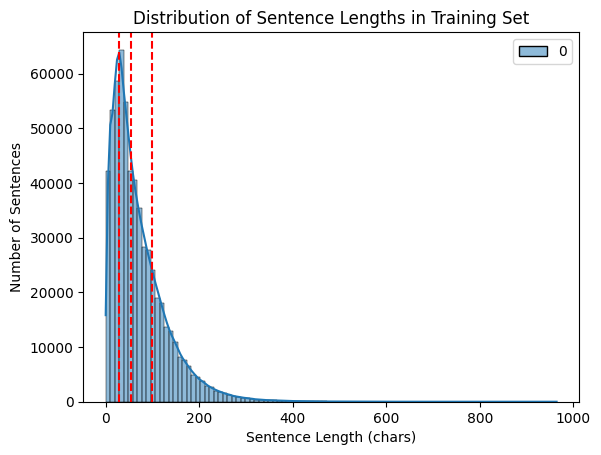

In [47]:
# sns.displot(train_lengths, kde=True)
quantiles = plot_lengths.quantile([.25, .5, .75])
print(quantiles)
sns.histplot(plot_lengths, bins=100, kde=True)
for q in quantiles.values:
    plt.axvline(q, 0, 1, color='r', ls='--')
plt.xlabel("Sentence Length (chars)")
plt.ylabel("Number of Sentences")
plt.title("Distribution of Sentence Lengths in Training Set")
plt.show()

## Tokenization

In [5]:
context_length = 1024
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [6]:
outputs = tokenizer(
    coca_dsdict["train"][:2]["text"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

In [7]:
print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(outputs['input_ids'])
print(coca_dsdict['train'][:2]['text'])
print([tokenizer.convert_ids_to_tokens(sentence) for sentence in outputs['input_ids']])

Input IDs length: 2
Input chunk lengths: [13, 6]
[[1870, 262, 411, 4499, 13870, 326, 467, 656, 5742, 514, 4620, 326, 764], [44, 76, 12, 71, 3020, 764]]
['And theres learned habits that go into helping us achieve that .', 'Mm-hmm .']
[['And', 'Ġthe', 'res', 'Ġlearned', 'Ġhabits', 'Ġthat', 'Ġgo', 'Ġinto', 'Ġhelping', 'Ġus', 'Ġachieve', 'Ġthat', 'Ġ.'], ['M', 'm', '-', 'h', 'mm', 'Ġ.']]


In [8]:
tokenized_data_path = '../data/coca_spoken/tokens/'

In [58]:
encoded_datasets = coca_dsdict.map(lambda sentence: tokenizer(sentence['text']), batched=True)
encoded_datasets.save_to_disk(tokenized_data_path)

Saving the dataset (1/1 shards): 100%|██████████| 600372/600372 [00:00<00:00, 1815063.37 examples/s]


In [61]:
print(encoded_datasets)
print(encoded_datasets['train'][0])
print(sum(len(x['input_ids']) for x in encoded_datasets['train']))

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 4802969
    })
    val: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 600371
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 600372
    })
})
{'text': 'He sees things very similar .', 'input_ids': [1544, 7224, 1243, 845, 2092, 764], 'attention_mask': [1, 1, 1, 1, 1, 1]}
79275294


### Loading tokenized dataset from disk

In [9]:
encoded_datasets = load_from_disk(tokenized_data_path)

In [10]:
encoded_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 4802969
    })
    val: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 600371
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 600372
    })
})

### Tokenized Data stats

In [22]:
plot_data = encoded_datasets['test']

# Tokenized sentence length distribution
def get_tokenized_sentence_lengths(data):
    return pd.DataFrame(len(s) for s in data['input_ids'])

plot_lengths = get_tokenized_sentence_lengths(plot_data)

         0
0.25   7.0
0.50  13.0
0.75  22.0


/om2/user/krmkrm/miniconda/envs/car1/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/om2/user/krmkrm/miniconda/envs/car1/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


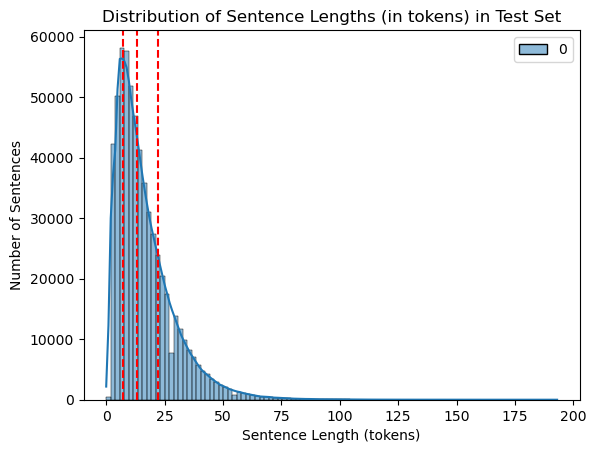

In [24]:
# sns.displot(train_lengths, kde=True)
quantiles = plot_lengths.quantile([.25, .5, .75])
print(quantiles)
sns.histplot(plot_lengths, bins=100, kde=True)
for q in quantiles.values:
    plt.axvline(q, 0, 1, color='r', ls='--')
plt.xlabel("Sentence Length (tokens)")
plt.ylabel("Number of Sentences")
plt.title("Distribution of Sentence Lengths (in tokens) in Test Set")
plt.show()

## Init GPT-2 model and config

In [11]:
configuration = GPT2Config()
model = GPT2LMHeadModel(configuration)
configuration = model.config
configuration

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.39.2",
  "use_cache": true,
  "vocab_size": 50257
}

In [12]:
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.4M parameters


### Data collator

The data collator will pad the tokens.
Should the tokens be padded beforehand in the tokenizer?
Should the tokens be padded to a specific length?
Should long sentences be truncated or excluded?

In [13]:
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
# mlm=True: autoencoding, mlm=False: autoregressive
# data_collator = DataCollatorWithPadding(tokenizer)

In [14]:
for i in range(5):
    print(encoded_datasets['train'][i])

{'text': 'Our next tune is a tune that Melissa sang right in the film .', 'input_ids': [5122, 1306, 14009, 318, 257, 14009, 326, 24164, 25889, 826, 287, 262, 2646, 764], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'text': "Most of the attention is on the night 's debates .", 'input_ids': [6943, 286, 262, 3241, 318, 319, 262, 1755, 705, 82, 15389, 764], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'text': 'Like most disabled people in Canada , she is horrified by any public sympathy for Robert Latimer .', 'input_ids': [7594, 749, 10058, 661, 287, 3340, 837, 673, 318, 32816, 416, 597, 1171, 20242, 329, 5199, 5476, 22723, 764], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'text': 'Thousands of Americans showed up to talk about issues , to listen to speeches , and most of all to vote .', 'input_ids': [37482, 286, 3399, 3751, 510, 284, 1561, 546, 2428, 837, 284, 6004, 284, 18138, 837, 290, 749, 286, 477, 284, 3015, 764], 'atten

In [15]:
tokenized_datasets = encoded_datasets.remove_columns(coca_dsdict["train"].column_names)

In [16]:
example_data_collation = data_collator([tokenized_datasets['train'][i] for i in range(40)])
for key in example_data_collation:
    print(f"{key} shape: {example_data_collation[key].shape}")

input_ids shape: torch.Size([40, 57])
attention_mask shape: torch.Size([40, 57])
labels shape: torch.Size([40, 57])


## Trainer

In [17]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.39.2', '0.28.0')

In [18]:
import torch
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA A100 80GB PCIe'

In [21]:
training_output_dir = '../models/test2/'
args = TrainingArguments(
    training_output_dir,
    per_device_train_batch_size=128, # change to fit GPU specs
    per_device_eval_batch_size=128,
    group_by_length=True, # bucketing
)

In [22]:
args.device

device(type='cuda', index=0)

In [23]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['val'],
)

/om2/user/krmkrm/miniconda/envs/car1/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [26]:
trainer.train(resume_from_checkpoint=True)

There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Step,Training Loss
19000,3.843400
19500,3.833500
20000,3.817400
20500,3.806000
21000,3.794900
21500,3.795200
22000,3.786000
22500,3.779900
23000,3.761200
23500,3.758900


KeyboardInterrupt: 

In [39]:
input_text = "Did you know that the first person to"
inputs = tokenizer.encode(input_text, return_tensors="pt")

In [30]:
trained_model = GPT2LMHeadModel.from_pretrained("../models/test2/checkpoint-37500")

In [22]:
outputs = trained_model.generate(inputs, max_length=50, num_return_sequences=1)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
generated_text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"The cat sits on the ground.1st..m., and the other one is the one that's going to be on the road.1. 1st......, and"

In [20]:
from transformers import set_seed

In [21]:
set_seed(2)

In [40]:
outputs = trained_model.generate(
    inputs,
    max_new_tokens=40,
    do_sample=True,
    top_k=50,
    # temperature=0.6,
)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
generated_text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Did you know that the first person to marry me?, the other guy?, who went to the White House? qwq @ ( Excerpt-from- " S  i  U.S : The day is'